In [406]:
import pandas as pd
import numpy as np
import mysql.connector
from mysql.connector import Error

# Carga de datos y creación de DB

Como la data del problema esta en el archivo trips.csv y se nos pide trabajar desde una DB en SQL, se creará la DB en MySQL la database trips, con la tabla movimientos en donde se almacenará la información

In [407]:
df = pd.read_csv('trips.csv')
df.columns

Index(['region', 'origin_coord', 'destination_coord', 'datetime',
       'datasource'],
      dtype='object')

In [408]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   region             100 non-null    object
 1   origin_coord       100 non-null    object
 2   destination_coord  100 non-null    object
 3   datetime           100 non-null    object
 4   datasource         100 non-null    object
dtypes: object(5)
memory usage: 4.0+ KB


In [409]:
df.head()

,region,origin_coord,destination_coord,datetime,datasource
0,Prague,POINT (14.4973794438195 50.00136875782316),POINT (14.43109483523328 50.04052930943246),2018-05-28 09:03:40,funny_car
1,Turin,POINT (7.672837913286881 44.9957109242058),POINT (7.720368637535126 45.06782385393849),2018-05-21 02:54:04,baba_car
2,Prague,POINT (14.32427345662177 50.00002074358429),POINT (14.47767895969969 50.09339790740321),2018-05-13 08:52:25,cheap_mobile
3,Turin,POINT (7.541509189114433 45.09160503827746),POINT (7.74528653441973 45.02628598341506),2018-05-06 09:49:16,bad_diesel_vehicles
4,Turin,POINT (7.614078119815749 45.13433106465422),POINT (7.527497142312585 45.03335051325654),2018-05-23 12:45:54,pt_search_app


In [410]:
# Definimos la función para crear la conexión al servidor
def create_server_connection(host_name, user_name, user_password):
    connection = None
    try:
        connection = mysql.connector.connect(
            host=host_name,
            user=user_name,
            passwd=user_password
        )
        print("MySQL Database connection successful")
    except Error as err:
        print(f"Error: '{err}'")

    return connection

# Definimos la función para crear la base de datos
def create_database(connection, query):
    cursor = connection.cursor()
    try:
        cursor.execute(query)
        print("Database created successfully")
    except Error as err:
        print(f"Error: '{err}'")

In [411]:
# Nos conectamos al servidor
connection = create_server_connection("localhost", "root", "NW_server_pw")
# Creamos la base de datos
create_database(connection, "CREATE DATABASE trips")

MySQL Database connection successful
Error: '1007 (HY000): Can't create database 'trips'; database exists'


In [412]:
def create_db_connection(host_name, user_name, user_password, db_name):
    connection = None
    try:
        connection = mysql.connector.connect(
            host=host_name,
            user=user_name,
            passwd=user_password,
            database=db_name
        )
        print("MySQL Database connection successful")
    except Error as err:
        print(f"Error: '{err}'")

    return connection

def execute_query(connection, query):
    cursor = connection.cursor()
    try:
        cursor.execute(query)
        connection.commit()
        print("Query successful")
    except Error as err:
        print(f"Error: '{err}'")

In [413]:
# Query para crear la tabla viajes
create_viaje_table = """
CREATE TABLE viajes (
  region VARCHAR(7) NOT NULL,
  origin_coord VARCHAR(50) NOT NULL,
  destination_coord VARCHAR(50) NOT NULL,
  datetime DATETIME NOT NULL,
  datasource VARCHAR(20) NOT NULL
  );
 """

# Nos conectamos a la base de datos
connection = create_db_connection("localhost", "root", "NW_server_pw", "trips")
# Ejecutamos la query
execute_query(connection, create_viaje_table) 

MySQL Database connection successful
Query successful


In [414]:
cols = "`,`".join([str(i) for i in df.columns.tolist()])
cursor = connection.cursor()

# Insertamos las filas del DataFrame una por una
for i,row in df.iterrows():
    sql = "INSERT INTO `viajes` (`" +cols + "`) VALUES (" + "%s,"*(len(row)-1) + "%s)"
    cursor.execute(sql, tuple(row))
    connection.commit()

In [415]:
# Terminamos la conexión con la base de datos
connection.close()

 # Conexión a la DB
 
 Ahora se asume que la información en la base de datos esta actualizada y solo se necesita conectarse desde Python para trabajar en el problema

In [416]:
# Nos conectamos a la base de datos 'trips'
connection = create_db_connection("localhost", "root", "NW_server_pw", "trips")

MySQL Database connection successful


In [417]:
# Cargamos la información de la base de datos a un dataframe
sql_query = pd.read_sql_query ('''
                               SELECT
                               *
                               FROM viajes
                               ''', connection)

data= pd.DataFrame(sql_query, columns = ["region", "origin_coord", "destination_coord",
                                        "datetime", "datasource"])
data.head()

,region,origin_coord,destination_coord,datetime,datasource
0,Prague,POINT (14.4973794438195 50.00136875782316),POINT (14.43109483523328 50.04052930943246),2018-05-28 09:03:40,funny_car
1,Turin,POINT (7.672837913286881 44.9957109242058),POINT (7.720368637535126 45.06782385393849),2018-05-21 02:54:04,baba_car
2,Prague,POINT (14.32427345662177 50.00002074358429),POINT (14.47767895969969 50.09339790740321),2018-05-13 08:52:25,cheap_mobile
3,Turin,POINT (7.541509189114433 45.09160503827746),POINT (7.74528653441973 45.02628598341506),2018-05-06 09:49:16,bad_diesel_vehicles
4,Turin,POINT (7.614078119815749 45.13433106465422),POINT (7.527497142312585 45.03335051325654),2018-05-23 12:45:54,pt_search_app


In [418]:
# Terminamos la conexión con la base de datos
connection.close()

# Problema 1

In [419]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.preprocessing import StandardScaler

In [420]:
# Definimos función que transforma las coordenadas en pares
def to_coord(col):
    aux = data[col]
    new_col = np.empty([len(aux),2])
    for i in range(len(aux)):
        x,y = aux[i][7:-1].split()
        new_col[i,:] = np.array([x,y]) 
    return new_col

In [513]:
# Coordenadas origen y destino en arrays numéricos
new_origin = to_coord('origin_coord')
new_destin = to_coord('destination_coord')

In [459]:
# Aislamos la hora (hh,mm,ss) de cada viaje 
hora = np.array([data['datetime'][i].time() for i in range(len(data))])
# Pasamos la hora a segundos de manera numérica
hora = np.array([hora[i].hour*(60**2)+hora[i].minute*60+hora[i].second for i in range(len(data))])

### K-means

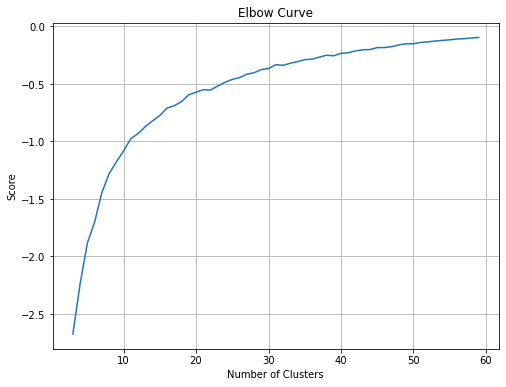

In [582]:
X = np.empty([len(data),4])
X[:,0] = new_origin[:,0]
X[:,1] = new_destin[:,0]
X[:,2] = new_origin[:,1]
X[:,3] = new_destin[:,1]

Nc = range(3, 60)
kmeans = [KMeans(n_clusters=i) for i in Nc]
score = [kmeans[i].fit(X).score(X) for i in range(len(kmeans))]
f = plt.figure()
f.set_figwidth(8)
f.set_figheight(6)
plt.plot(Nc,score)
plt.grid()
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')

plt.show()

El gráfico sugiere una división de 21 grupos 

In [478]:
kmeans = KMeans(n_clusters=21).fit(X)
centroids = kmeans.cluster_centers_

### Agrupamos los viajes

En base a los 3 k-means realizados, agrupamos los viajes según la predicción de los modelos ajustados

In [464]:
labels = kmeans.predict(X)

In [465]:
praga = [[] for i in range(len(centroids_praga))]
for i in range(len(labels_praga)):
    praga[labels_praga[i]].append(praga_ind[i])
    
turin = [[] for i in range(len(centroids_turin))]
for i in range(len(labels_turin)):
    turin[labels_turin[i]].append(turin_ind[i])
    
ham = [[] for i in range(len(centroids_ham))]
for i in range(len(labels_ham)):
    ham[labels_ham[i]].append(hamburg_ind[i])
    
print('Grupos Prague:' + str(praga))
print('Grupos Turin:' + str(turin))
print('Grupos Hamburg:' + str(ham))

Grupos Prague:[[17, 29, 40, 44, 64, 99], [26, 32, 54, 73], [2, 34, 47, 52, 61, 97], [13, 27, 60, 67, 69, 79], [0, 15, 36, 42, 50, 57, 77], [21, 35, 53, 59, 95]]
Grupos Turin:[[3, 16, 46, 49, 58, 78, 84], [18, 31, 33, 45, 62, 70, 71, 86], [4, 41, 87], [56, 66, 76], [1, 37, 43, 63, 65], [7, 14, 20, 72], [12, 24, 30, 68, 74], [8, 28, 90]]
Grupos Hamburg:[[9, 39, 82, 88, 92, 96], [5, 6, 19, 75, 94], [10, 23, 48], [22, 38, 55, 81, 83], [80, 98], [51, 85, 91, 93], [11, 25, 89]]


In [475]:
data.iloc[ham[0],:]

,region,origin_coord,destination_coord,datetime,datasource
9,Hamburg,POINT (10.05260098579818 53.53497739746809),POINT (10.05889649564977 53.49486429314853),2018-05-04 00:46:12,cheap_mobile
39,Hamburg,POINT (10.2154964127794 53.53161090271701),POINT (10.20544652088819 53.5064112329052),2018-05-18 11:07:29,cheap_mobile
82,Hamburg,POINT (10.08064772413434 53.5438877700869),POINT (9.985427968556252 53.41711096758155),2018-05-29 07:02:25,cheap_mobile
88,Hamburg,POINT (10.15410920623684 53.53092417407957),POINT (10.1041201879328 53.42920211427293),2018-05-27 17:41:17,funny_car
92,Hamburg,POINT (10.17378993097742 53.5467336774148),POINT (10.21529787231755 53.50485266884467),2018-05-21 04:06:11,pt_search_app
96,Hamburg,POINT (9.996714798980491 53.52203690589671),POINT (10.17431393081631 53.51796499041119),2018-05-23 12:43:17,baba_car


# Problema 2

In [396]:
# Definimos función que transforma las coordenadas en pares para un dataframe dado
def to_coord_reg(df, col):
    aux = df[col]
    new_col = np.empty([len(aux),2])
    for i in range(len(aux)):
        x,y = aux[aux.index[i]][7:-1].split()
        new_col[i,:] = np.array([x,y]) 
    return new_col

In [501]:
#Se asume que el bounding box se entrega como coordenadas x1,y1,x2,y2, donde x1<=x2 e y1<=y2
#Se entiende que tanto el origen como el destino tienen que estar dentro del bounding box
def weekly_mean(x1,y1,x2,y2,region):
    #query región
    data_reg = data[data['region'] == region].copy()
    
    #pasamos las coordenadas a pares numéricos
    new_origen = to_coord_reg(data_reg, 'origin_coord')
    new_destin = to_coord_reg(data_reg, 'destination_coord')
    
    #Se filtra los viajes dentro de la bounding box
    low_bound = [all(new_origen[i] >= [x1,y1]) and all(new_destin[i] >= [x1,y1]) 
                 for i in range(len(data_reg))]
    up_bound = [all(new_origen[i] <= [x2,y2]) and all(new_destin[i] <= [x2,y2]) 
                 for i in range(len(data_reg))]
    #query bounding box
    data_bound = data_reg[low_bound and up_bound]
    
    #agrupamos por semana y sacamos promedio
    week_mean = data_bound.groupby(pd.Grouper(key='datetime', freq='W-MON', label='left')
                        )['datetime'].count().mean()
    return week_mean

In [502]:
weekly_mean(0,0,100,100,'Prague')

6.8